In [2]:
"""
Created on Sat Apr 20 20:15:16 2019

@author: smk5g5

"""
import pickle
import pandas as pd
import data_processing as dp
from pandas import DataFrame
from sklearn.model_selection import train_test_split
import numpy as np
from keras.layers import Input
import keras.utils.np_utils as kutils
import time
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Flatten
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from keras.layers import Convolution2D as Conv2D
from keras.layers import MaxPooling2D
from keras.callbacks import EarlyStopping
import json
from keras.models import Model

import tensorflow as tf
import os
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score, matthews_corrcoef
from sklearn.metrics import precision_score, recall_score, f1_score
remark = ''  # The mark written in the result file.
import time
import numpy as np
import pickle
import keras.layers.core as core
import keras.layers.convolutional as conv
import keras.models as models
from keras.models import Model
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, LearningRateScheduler, History
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1, l2, l1_l2
import keras.metrics
from keras.optimizers import Nadam, Adam
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score, matthews_corrcoef
import data_processing
import os
from sklearn import svm
from sklearn.manifold import TSNE
from matplotlib import offsetbox
from sklearn.metrics import accuracy_score, recall_score

gpu_id = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_id)
os.system('echo $CUDA_VISIBLE_DEVICES')

tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
tf.Session(config=tf_config)


/home/smk5g5/.conda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def read_composite_data(file):
    df = pd.read_csv(file,sep="\s+",names=["Sequence","Secondary_str","Chr_loc","Label"])
    return(df)

def subselect_list(indices,mylist):
    final = [mylist[i] for i in indices]
    return  final

def get_all_seq(df):
    seq = []
    secstr = []
    label = []
    for indexs in df.index:
        seq.append(df.loc[indexs].values[0])
        secstr.append(df.loc[indexs].values[1])
        label.append(df.loc[indexs].values[3])
    return seq,secstr,label

def onehotkey(seq, tag):
     """
     one hot coding
     :param seq:
     :param tag:
     :return:
     """
     tag = np.array(tag)
#     for num in range(len(seq)):
#         seq[num] = seq[num].strip('\n')
     letterDict = {}
     letterDict["A"] = 0
     letterDict["C"] = 1
     letterDict["G"] = 2
     letterDict["U"] = 3
     letterDict["T"] = 3
     CategoryLen = 4
     probMatr = np.zeros((len(seq),len(seq[0]), CategoryLen))
     sampleNo = 0
     for sequence in seq:
         RNANo = 0
         for RNA in sequence:
             try:
                 index = letterDict[RNA]
                 probMatr[sampleNo][RNANo][index] = 1
                 RNANo += 1
             except:
                 RNANo += 1
         sampleNo += 1
     return probMatr, tag

#          'H' => 4186861, (Nucleotides in Hairpin context)
#          'F' => 2584467, (Nucleotides in dangling start shape)
#          'M' => 1081741, (Nucleotides in multiloops)
#          'T' => 2595203, (Nucleotides in dangling ends)
#          'S' => 10667944, (Nucleotides in Stems)
#          'I' => 2968228 (Nucleotides in interntal loops)
# def onehotkey_sec(seq, tag):
#      """
#      one hot coding
#      :param seq:
#      :param tag:
#      :return:
#      """
#      tag = np.array(tag)
# #     for num in range(len(seq)):
# #         seq[num] = seq[num].strip('\n')
#      letterDict = {}
#      letterDict["H"] = 0
#      letterDict["F"] = 1
#      letterDict["M"] = 2
#      letterDict["S"] = 3
#      letterDict["T"] = 4
#      letterDict["I"] = 5
#      CategoryLen = 6
#      probMatr = np.zeros((len(seq),len(seq[0]), CategoryLen))
#      sampleNo = 0
#      for sequence in seq:
#          RNANo = 0
#          for RNA in sequence:
#              try:
#                  index = letterDict[RNA]
#                  probMatr[sampleNo][RNANo][index] = 1
#                  RNANo += 1
#              except:
#                  RNANo += 1
#          sampleNo += 1
#      return probMatr, tag

In [11]:
def MCNN(trainX1,trainY1,valX1,valY1,input_1,i):
    onehot_x = conv.Conv1D(5, 10, kernel_initializer='glorot_normal',kernel_regularizer=l2(0.04), padding='valid', name='0')(input_1)
    onehot_x = Dropout(0.6)(onehot_x)
    onehot_x = keras.layers.advanced_activations.PReLU(alpha_initializer='zeros', alpha_regularizer=None,alpha_constraint=None, shared_axes=None)(onehot_x)
    onehot_x = core.Flatten()(onehot_x)
    onehot_x2 = conv.Conv1D(9, 4, kernel_initializer='glorot_normal',kernel_regularizer=l2(0.02), padding='valid', name='1')(input_1)
    onehot_x2 = Dropout(0.4)(onehot_x2)
    onehot_x2 = keras.layers.advanced_activations.PReLU(alpha_initializer='zeros', alpha_regularizer=None,alpha_constraint=None, shared_axes=None)(onehot_x2)
    onehot_x2 = core.Flatten()(onehot_x2)
    output_onehot_seq = concatenate([onehot_x, onehot_x2], axis=-1)
    dense_out = Dense(100, kernel_initializer='glorot_normal', activation='softplus', name='dense_concat')(output_onehot_seq)
    out = Dense(2, activation="softmax", kernel_initializer='glorot_normal', name='6')(dense_out)
    ########## Set Net ##########
    cnn = Model(inputs=input_1, outputs=out)
    cnn.summary()
    nadam = Nadam(lr=0.001)
    #early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')
    cnn.compile(loss='binary_crossentropy', optimizer=nadam, metrics=[keras.metrics.binary_accuracy])  # Nadam
    early_stopping = EarlyStopping(monitor='val_loss', patience=20)
    checkpointer = ModelCheckpoint(filepath='%d-secstr_seq_denseconcat_100.h5' % i, verbose=1,save_best_only=True, monitor='val_loss', mode='min')
    fitHistory = cnn.fit(trainX1, trainY1, batch_size=1200, nb_epoch=500,validation_data=(valX1,valY1),callbacks=[checkpointer,early_stopping])
    history_dict = fitHistory.history
    myjson_file = "myhist_" +"dict_secstr_seq_denseconcat_" +str(i)
    json.dump(history_dict, open(myjson_file, 'w'))
    return cnn, fitHistory

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 7.0)
import seaborn as sns

In [13]:
for i in range(10):
    testfile = "combined_Pseudouridine_test_%d.txt" % i
    trainfile = "combined_Pseudouridine_trainval_cdhit_%d.txt" % i
    valfile = "combined_Pseudouridine_valid_%d.txt" % i
    train = read_composite_data(trainfile)
    train_shuffled = train.sample(frac=1)
    test = read_composite_data(testfile)
    test_shuffled = test.sample(frac=1)
    validation = read_composite_data(valfile)
    valid_shuffle = validation.sample(frac=1)
    seq,secstr,label = get_all_seq(train_shuffled)
    seq_val,secstr_val,label_val = get_all_seq(valid_shuffle)
    trainX, trainY = onehotkey(seq, label)
#     trainX1, trainY = onehotkey_sec(secstr, label)
    class_weight_list = compute_class_weight('balanced', np.unique(trainY), trainY)
    class_weights = dict(zip(np.unique(trainY), class_weight_list))
    trainY = np_utils.to_categorical(trainY,2)
    row1,col1 = trainX[0].shape
    trainX.shape = (trainX.shape[0], row1,col1)
    input_1 = Input(shape=(row1,col1))
#     row2,col2 = trainX2[0].shape
#     trainX2.shape = (trainX2.shape[0], row2,col2)
#     input_2 = Input(shape=(row2,col2))
    trainY = trainY.reshape(-1,2)
    ValX, ValY = onehotkey(seq_val, label_val)
#     ValX1,ValY = onehotkey_sec(secstr_val, label_val)
    ValY = np_utils.to_categorical(ValY,2)
    ValY = ValY.reshape(-1,2)
    cnn, fitHistory = MCNN(trainX,trainY,ValX,ValY,input_1,i,class_weights)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 51, 4)        0                                            
__________________________________________________________________________________________________
0 (Conv1D)                      (None, 42, 5)        205         input_3[0][0]                    
__________________________________________________________________________________________________
1 (Conv1D)                      (None, 48, 9)        153         input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 42, 5)        0           0[0][0]                          
__________________________________________________________________________________________________
dropout_2 

/home/smk5g5/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 10734 samples, validate on 5826 samples
Epoch 1/500
10734/10734 [==============================] - 2s 159us/step - loss: 1.0740 - binary_accuracy: 0.5640 - val_loss: 0.9794 - val_binary_accuracy: 0.4851

Epoch 00001: val_loss improved from inf to 0.97939, saving model to 0-secstr_seq_denseconcat_100.h5
Epoch 2/500
10734/10734 [==============================] - 0s 11us/step - loss: 0.9421 - binary_accuracy: 0.5772 - val_loss: 0.9247 - val_binary_accuracy: 0.5836

Epoch 00002: val_loss improved from 0.97939 to 0.92467, saving model to 0-secstr_seq_denseconcat_100.h5
Epoch 3/500
10734/10734 [==============================] - 0s 11us/step - loss: 0.8887 - binary_accuracy: 0.6417 - val_loss: 0.9413 - val_binary_accuracy: 0.5225

Epoch 00003: val_loss did not improve from 0.92467
Epoch 4/500
10734/10734 [==============================] - 0s 10us/step - loss: 0.8329 - binary_accuracy: 0.6836 - val_loss: 0.8935 - val_binary_accuracy: 0.5877

Epoch 00004: val_loss improved from 0.92467

10734/10734 [==============================] - 0s 9us/step - loss: 0.5182 - binary_accuracy: 0.7802 - val_loss: 0.5158 - val_binary_accuracy: 0.7863

Epoch 00036: val_loss did not improve from 0.48440
Epoch 37/500
10734/10734 [==============================] - 0s 12us/step - loss: 0.5216 - binary_accuracy: 0.7843 - val_loss: 0.5190 - val_binary_accuracy: 0.7824

Epoch 00037: val_loss did not improve from 0.48440
Epoch 38/500
10734/10734 [==============================] - 0s 10us/step - loss: 0.5206 - binary_accuracy: 0.7822 - val_loss: 0.5223 - val_binary_accuracy: 0.7777

Epoch 00038: val_loss did not improve from 0.48440
Epoch 39/500
10734/10734 [==============================] - 0s 11us/step - loss: 0.5204 - binary_accuracy: 0.7808 - val_loss: 0.5000 - val_binary_accuracy: 0.7916

Epoch 00039: val_loss did not improve from 0.48440
Epoch 40/500
10734/10734 [==============================] - 0s 11us/step - loss: 0.5147 - binary_accuracy: 0.7772 - val_loss: 0.5027 - val_binary_accuracy

10734/10734 [==============================] - 0s 10us/step - loss: 0.4659 - binary_accuracy: 0.7930 - val_loss: 0.4496 - val_binary_accuracy: 0.8107

Epoch 00073: val_loss did not improve from 0.40991
Epoch 74/500
10734/10734 [==============================] - 0s 14us/step - loss: 0.4755 - binary_accuracy: 0.7963 - val_loss: 0.4730 - val_binary_accuracy: 0.7933

Epoch 00074: val_loss did not improve from 0.40991
Epoch 75/500
10734/10734 [==============================] - 0s 11us/step - loss: 0.4736 - binary_accuracy: 0.7947 - val_loss: 0.4826 - val_binary_accuracy: 0.7865

Epoch 00075: val_loss did not improve from 0.40991
Epoch 76/500
10734/10734 [==============================] - 0s 11us/step - loss: 0.4675 - binary_accuracy: 0.7970 - val_loss: 0.4488 - val_binary_accuracy: 0.8108

Epoch 00076: val_loss did not improve from 0.40991
Epoch 77/500
10734/10734 [==============================] - 0s 8us/step - loss: 0.4733 - binary_accuracy: 0.8007 - val_loss: 0.5134 - val_binary_accuracy

/home/smk5g5/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 10798 samples, validate on 5826 samples
Epoch 1/500
10798/10798 [==============================] - 1s 67us/step - loss: 1.1462 - binary_accuracy: 0.4478 - val_loss: 0.9674 - val_binary_accuracy: 0.6033

Epoch 00001: val_loss improved from inf to 0.96741, saving model to 1-secstr_seq_denseconcat_100.h5
Epoch 2/500
10798/10798 [==============================] - 0s 9us/step - loss: 0.9808 - binary_accuracy: 0.5627 - val_loss: 0.9371 - val_binary_accuracy: 0.6341

Epoch 00002: val_loss improved from 0.96741 to 0.93711, saving model to 1-secstr_seq_denseconcat_100.h5
Epoch 3/500
10798/10798 [==============================] - 0s 9us/step - loss: 0.9245 - binary_accuracy: 0.5982 - val_loss: 0.7897 - val_binary_accuracy: 0.8450

Epoch 00003: val_loss improved from 0.93711 to 0.78972, saving model to 1-secstr_seq_denseconcat_100.h5
Epoch 4/500
10798/10798 [==============================] - 0s 9us/step - loss: 0.8702 - binary_accuracy: 0.6673 - val_loss: 0.7549 - val_binary_accuracy: 0.

10798/10798 [==============================] - 0s 9us/step - loss: 0.5376 - binary_accuracy: 0.7660 - val_loss: 0.5138 - val_binary_accuracy: 0.7877

Epoch 00036: val_loss did not improve from 0.44340
Epoch 37/500
10798/10798 [==============================] - 0s 9us/step - loss: 0.5388 - binary_accuracy: 0.7676 - val_loss: 0.5141 - val_binary_accuracy: 0.7868

Epoch 00037: val_loss did not improve from 0.44340
Epoch 38/500
10798/10798 [==============================] - 0s 10us/step - loss: 0.5369 - binary_accuracy: 0.7667 - val_loss: 0.4595 - val_binary_accuracy: 0.8222

Epoch 00038: val_loss did not improve from 0.44340
Epoch 39/500
10798/10798 [==============================] - 0s 15us/step - loss: 0.5362 - binary_accuracy: 0.7675 - val_loss: 0.5005 - val_binary_accuracy: 0.7951

Epoch 00039: val_loss did not improve from 0.44340
Epoch 40/500
10798/10798 [==============================] - 0s 12us/step - loss: 0.5297 - binary_accuracy: 0.7661 - val_loss: 0.4550 - val_binary_accuracy:

/home/smk5g5/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 10771 samples, validate on 5826 samples
Epoch 1/500
10771/10771 [==============================] - 1s 73us/step - loss: 0.9950 - binary_accuracy: 0.5280 - val_loss: 0.8781 - val_binary_accuracy: 0.7492

Epoch 00001: val_loss improved from inf to 0.87814, saving model to 2-secstr_seq_denseconcat_100.h5
Epoch 2/500
10771/10771 [==============================] - 0s 9us/step - loss: 0.9049 - binary_accuracy: 0.6327 - val_loss: 1.0193 - val_binary_accuracy: 0.3072

Epoch 00002: val_loss did not improve from 0.87814
Epoch 3/500
10771/10771 [==============================] - 0s 12us/step - loss: 0.8631 - binary_accuracy: 0.6230 - val_loss: 0.7324 - val_binary_accuracy: 0.8426

Epoch 00003: val_loss improved from 0.87814 to 0.73245, saving model to 2-secstr_seq_denseconcat_100.h5
Epoch 4/500
10771/10771 [==============================] - 0s 9us/step - loss: 0.8049 - binary_accuracy: 0.7021 - val_loss: 0.7284 - val_binary_accuracy: 0.7918

Epoch 00004: val_loss improved from 0.73245 to

10771/10771 [==============================] - 0s 10us/step - loss: 0.5068 - binary_accuracy: 0.7756 - val_loss: 0.4785 - val_binary_accuracy: 0.7999

Epoch 00037: val_loss did not improve from 0.45201
Epoch 38/500
10771/10771 [==============================] - 0s 9us/step - loss: 0.4971 - binary_accuracy: 0.7877 - val_loss: 0.5169 - val_binary_accuracy: 0.7707

Epoch 00038: val_loss did not improve from 0.45201
Epoch 39/500
10771/10771 [==============================] - 0s 9us/step - loss: 0.4969 - binary_accuracy: 0.7856 - val_loss: 0.4882 - val_binary_accuracy: 0.7903

Epoch 00039: val_loss did not improve from 0.45201
Epoch 40/500
10771/10771 [==============================] - 0s 15us/step - loss: 0.4988 - binary_accuracy: 0.7890 - val_loss: 0.5357 - val_binary_accuracy: 0.7554

Epoch 00040: val_loss did not improve from 0.45201
Epoch 41/500
10771/10771 [==============================] - 0s 9us/step - loss: 0.4923 - binary_accuracy: 0.7816 - val_loss: 0.4536 - val_binary_accuracy: 

/home/smk5g5/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 10721 samples, validate on 5826 samples
Epoch 1/500
10721/10721 [==============================] - 1s 75us/step - loss: 1.0419 - binary_accuracy: 0.4854 - val_loss: 0.8592 - val_binary_accuracy: 0.7935

Epoch 00001: val_loss improved from inf to 0.85921, saving model to 3-secstr_seq_denseconcat_100.h5
Epoch 2/500
10721/10721 [==============================] - 0s 11us/step - loss: 0.9376 - binary_accuracy: 0.5891 - val_loss: 0.8135 - val_binary_accuracy: 0.8054

Epoch 00002: val_loss improved from 0.85921 to 0.81348, saving model to 3-secstr_seq_denseconcat_100.h5
Epoch 3/500
10721/10721 [==============================] - 0s 8us/step - loss: 0.8782 - binary_accuracy: 0.6595 - val_loss: 1.0241 - val_binary_accuracy: 0.4006

Epoch 00003: val_loss did not improve from 0.81348
Epoch 4/500
10721/10721 [==============================] - 0s 8us/step - loss: 0.8250 - binary_accuracy: 0.6700 - val_loss: 0.7034 - val_binary_accuracy: 0.8318

Epoch 00004: val_loss improved from 0.81348 to

10721/10721 [==============================] - 0s 10us/step - loss: 0.5266 - binary_accuracy: 0.7721 - val_loss: 0.5853 - val_binary_accuracy: 0.7225

Epoch 00037: val_loss did not improve from 0.48872
Epoch 38/500
10721/10721 [==============================] - 0s 10us/step - loss: 0.5220 - binary_accuracy: 0.7664 - val_loss: 0.4674 - val_binary_accuracy: 0.8133

Epoch 00038: val_loss improved from 0.48872 to 0.46739, saving model to 3-secstr_seq_denseconcat_100.h5
Epoch 39/500
10721/10721 [==============================] - 0s 9us/step - loss: 0.5172 - binary_accuracy: 0.7813 - val_loss: 0.4998 - val_binary_accuracy: 0.7842

Epoch 00039: val_loss did not improve from 0.46739
Epoch 40/500
10721/10721 [==============================] - 0s 9us/step - loss: 0.5216 - binary_accuracy: 0.7789 - val_loss: 0.5489 - val_binary_accuracy: 0.7467

Epoch 00040: val_loss did not improve from 0.46739
Epoch 41/500
10721/10721 [==============================] - 0s 9us/step - loss: 0.5138 - binary_accura

10721/10721 [==============================] - 0s 9us/step - loss: 0.4756 - binary_accuracy: 0.7885 - val_loss: 0.4416 - val_binary_accuracy: 0.8162

Epoch 00074: val_loss did not improve from 0.39720
Epoch 75/500
10721/10721 [==============================] - 0s 9us/step - loss: 0.4713 - binary_accuracy: 0.7976 - val_loss: 0.4440 - val_binary_accuracy: 0.8122

Epoch 00075: val_loss did not improve from 0.39720
Epoch 76/500
10721/10721 [==============================] - 0s 10us/step - loss: 0.4697 - binary_accuracy: 0.7944 - val_loss: 0.4398 - val_binary_accuracy: 0.8139

Epoch 00076: val_loss did not improve from 0.39720
Epoch 77/500
10721/10721 [==============================] - 0s 9us/step - loss: 0.4811 - binary_accuracy: 0.7899 - val_loss: 0.5072 - val_binary_accuracy: 0.7664

Epoch 00077: val_loss did not improve from 0.39720
Epoch 78/500
10721/10721 [==============================] - 0s 13us/step - loss: 0.4691 - binary_accuracy: 0.7975 - val_loss: 0.4842 - val_binary_accuracy: 

/home/smk5g5/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 10809 samples, validate on 5826 samples
Epoch 1/500
10809/10809 [==============================] - 1s 76us/step - loss: 0.9930 - binary_accuracy: 0.5045 - val_loss: 0.7826 - val_binary_accuracy: 0.8562

Epoch 00001: val_loss improved from inf to 0.78256, saving model to 4-secstr_seq_denseconcat_100.h5
Epoch 2/500
10809/10809 [==============================] - 0s 11us/step - loss: 0.9087 - binary_accuracy: 0.6297 - val_loss: 0.6255 - val_binary_accuracy: 0.9095

Epoch 00002: val_loss improved from 0.78256 to 0.62553, saving model to 4-secstr_seq_denseconcat_100.h5
Epoch 3/500
10809/10809 [==============================] - 0s 11us/step - loss: 0.8806 - binary_accuracy: 0.6580 - val_loss: 0.8968 - val_binary_accuracy: 0.5621

Epoch 00003: val_loss did not improve from 0.62553
Epoch 4/500
10809/10809 [==============================] - 0s 11us/step - loss: 0.8318 - binary_accuracy: 0.6495 - val_loss: 0.6722 - val_binary_accuracy: 0.8577

Epoch 00004: val_loss did not improve from 0

10809/10809 [==============================] - 0s 10us/step - loss: 0.5582 - binary_accuracy: 0.7782 - val_loss: 0.6283 - val_binary_accuracy: 0.6984

Epoch 00037: val_loss did not improve from 0.37094
Epoch 38/500
10809/10809 [==============================] - 0s 10us/step - loss: 0.5509 - binary_accuracy: 0.7477 - val_loss: 0.6126 - val_binary_accuracy: 0.7144

Epoch 00038: val_loss did not improve from 0.37094
Epoch 39/500
10809/10809 [==============================] - 0s 9us/step - loss: 0.5509 - binary_accuracy: 0.7534 - val_loss: 0.4931 - val_binary_accuracy: 0.8069

Epoch 00039: val_loss did not improve from 0.37094
Epoch 40/500
10809/10809 [==============================] - 0s 13us/step - loss: 0.5464 - binary_accuracy: 0.7735 - val_loss: 0.3903 - val_binary_accuracy: 0.8773

Epoch 00040: val_loss did not improve from 0.37094
Epoch 41/500
10809/10809 [==============================] - 0s 11us/step - loss: 0.5440 - binary_accuracy: 0.7828 - val_loss: 0.4552 - val_binary_accuracy

/home/smk5g5/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 10808 samples, validate on 5826 samples
Epoch 1/500
10808/10808 [==============================] - 1s 82us/step - loss: 1.1279 - binary_accuracy: 0.4394 - val_loss: 0.7447 - val_binary_accuracy: 0.8896

Epoch 00001: val_loss improved from inf to 0.74474, saving model to 5-secstr_seq_denseconcat_100.h5
Epoch 2/500
10808/10808 [==============================] - 0s 9us/step - loss: 0.9586 - binary_accuracy: 0.5994 - val_loss: 0.5868 - val_binary_accuracy: 0.9089

Epoch 00002: val_loss improved from 0.74474 to 0.58684, saving model to 5-secstr_seq_denseconcat_100.h5
Epoch 3/500
10808/10808 [==============================] - 0s 14us/step - loss: 0.9181 - binary_accuracy: 0.6551 - val_loss: 1.3756 - val_binary_accuracy: 0.1102

Epoch 00003: val_loss did not improve from 0.58684
Epoch 4/500
10808/10808 [==============================] - 0s 11us/step - loss: 0.8888 - binary_accuracy: 0.5708 - val_loss: 1.0227 - val_binary_accuracy: 0.4056

Epoch 00004: val_loss did not improve from 0.


Epoch 00036: val_loss did not improve from 0.44799
Epoch 37/500
10808/10808 [==============================] - 0s 10us/step - loss: 0.5812 - binary_accuracy: 0.7423 - val_loss: 0.7274 - val_binary_accuracy: 0.6397

Epoch 00037: val_loss did not improve from 0.44799
Epoch 38/500
10808/10808 [==============================] - 0s 10us/step - loss: 0.5805 - binary_accuracy: 0.7355 - val_loss: 0.4833 - val_binary_accuracy: 0.8292

Epoch 00038: val_loss did not improve from 0.44799
Epoch 39/500
10808/10808 [==============================] - 0s 13us/step - loss: 0.5787 - binary_accuracy: 0.7629 - val_loss: 1.0817 - val_binary_accuracy: 0.3666

Epoch 00039: val_loss did not improve from 0.44799
Epoch 40/500
10808/10808 [==============================] - 0s 11us/step - loss: 0.5985 - binary_accuracy: 0.6850 - val_loss: 1.0486 - val_binary_accuracy: 0.3862

Epoch 00040: val_loss did not improve from 0.44799
Epoch 41/500
10808/10808 [==============================] - 0s 9us/step - loss: 0.5949 -

10808/10808 [==============================] - 0s 14us/step - loss: 0.5232 - binary_accuracy: 0.7282 - val_loss: 0.4480 - val_binary_accuracy: 0.8230

Epoch 00074: val_loss did not improve from 0.37508
Epoch 75/500
10808/10808 [==============================] - 0s 11us/step - loss: 0.5147 - binary_accuracy: 0.7821 - val_loss: 0.5130 - val_binary_accuracy: 0.7741

Epoch 00075: val_loss did not improve from 0.37508
Epoch 76/500
10808/10808 [==============================] - 0s 9us/step - loss: 0.5104 - binary_accuracy: 0.7743 - val_loss: 0.4989 - val_binary_accuracy: 0.7824

Epoch 00076: val_loss did not improve from 0.37508
Epoch 77/500
10808/10808 [==============================] - 0s 10us/step - loss: 0.5121 - binary_accuracy: 0.7727 - val_loss: 0.8081 - val_binary_accuracy: 0.5578

Epoch 00077: val_loss did not improve from 0.37508
Epoch 78/500
10808/10808 [==============================] - 0s 9us/step - loss: 0.5289 - binary_accuracy: 0.7222 - val_loss: 0.4286 - val_binary_accuracy:

/home/smk5g5/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 10791 samples, validate on 5826 samples
Epoch 1/500
10791/10791 [==============================] - 1s 95us/step - loss: 1.2120 - binary_accuracy: 0.3837 - val_loss: 0.8755 - val_binary_accuracy: 0.8033

Epoch 00001: val_loss improved from inf to 0.87552, saving model to 6-secstr_seq_denseconcat_100.h5
Epoch 2/500
10791/10791 [==============================] - 0s 10us/step - loss: 0.9799 - binary_accuracy: 0.5815 - val_loss: 0.8945 - val_binary_accuracy: 0.7245

Epoch 00002: val_loss did not improve from 0.87552
Epoch 3/500
10791/10791 [==============================] - 0s 10us/step - loss: 0.9207 - binary_accuracy: 0.6150 - val_loss: 0.8557 - val_binary_accuracy: 0.7453

Epoch 00003: val_loss improved from 0.87552 to 0.85568, saving model to 6-secstr_seq_denseconcat_100.h5
Epoch 4/500
10791/10791 [==============================] - 0s 10us/step - loss: 0.8721 - binary_accuracy: 0.6594 - val_loss: 0.8262 - val_binary_accuracy: 0.7432

Epoch 00004: val_loss improved from 0.85568 

10791/10791 [==============================] - 0s 10us/step - loss: 0.5227 - binary_accuracy: 0.7789 - val_loss: 0.5272 - val_binary_accuracy: 0.7751

Epoch 00036: val_loss did not improve from 0.44713
Epoch 37/500
10791/10791 [==============================] - 0s 9us/step - loss: 0.5176 - binary_accuracy: 0.7717 - val_loss: 0.4420 - val_binary_accuracy: 0.8388

Epoch 00037: val_loss improved from 0.44713 to 0.44204, saving model to 6-secstr_seq_denseconcat_100.h5
Epoch 38/500
10791/10791 [==============================] - 0s 9us/step - loss: 0.5257 - binary_accuracy: 0.7752 - val_loss: 0.5301 - val_binary_accuracy: 0.7741

Epoch 00038: val_loss did not improve from 0.44204
Epoch 39/500
10791/10791 [==============================] - 0s 9us/step - loss: 0.5114 - binary_accuracy: 0.7785 - val_loss: 0.4866 - val_binary_accuracy: 0.8026

Epoch 00039: val_loss did not improve from 0.44204
Epoch 40/500
10791/10791 [==============================] - 0s 9us/step - loss: 0.5133 - binary_accurac

/home/smk5g5/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 10860 samples, validate on 5826 samples
Epoch 1/500
10860/10860 [==============================] - 1s 95us/step - loss: 0.9764 - binary_accuracy: 0.5578 - val_loss: 0.9505 - val_binary_accuracy: 0.5336

Epoch 00001: val_loss improved from inf to 0.95048, saving model to 7-secstr_seq_denseconcat_100.h5
Epoch 2/500
10860/10860 [==============================] - 0s 10us/step - loss: 0.8967 - binary_accuracy: 0.6241 - val_loss: 0.9222 - val_binary_accuracy: 0.5663

Epoch 00002: val_loss improved from 0.95048 to 0.92224, saving model to 7-secstr_seq_denseconcat_100.h5
Epoch 3/500
10860/10860 [==============================] - 0s 9us/step - loss: 0.8378 - binary_accuracy: 0.6777 - val_loss: 0.8575 - val_binary_accuracy: 0.6505

Epoch 00003: val_loss improved from 0.92224 to 0.85752, saving model to 7-secstr_seq_denseconcat_100.h5
Epoch 4/500
10860/10860 [==============================] - 0s 9us/step - loss: 0.7980 - binary_accuracy: 0.6948 - val_loss: 0.6852 - val_binary_accuracy: 0

10860/10860 [==============================] - 0s 11us/step - loss: 0.5103 - binary_accuracy: 0.7780 - val_loss: 0.7361 - val_binary_accuracy: 0.6147

Epoch 00037: val_loss did not improve from 0.37458
Epoch 38/500
10860/10860 [==============================] - 0s 10us/step - loss: 0.5098 - binary_accuracy: 0.7710 - val_loss: 0.4254 - val_binary_accuracy: 0.8440

Epoch 00038: val_loss did not improve from 0.37458
Epoch 39/500
10860/10860 [==============================] - 0s 10us/step - loss: 0.5050 - binary_accuracy: 0.7958 - val_loss: 0.4761 - val_binary_accuracy: 0.8067

Epoch 00039: val_loss did not improve from 0.37458
Epoch 40/500
10860/10860 [==============================] - 0s 9us/step - loss: 0.5048 - binary_accuracy: 0.7924 - val_loss: 0.3652 - val_binary_accuracy: 0.8823

Epoch 00040: val_loss improved from 0.37458 to 0.36518, saving model to 7-secstr_seq_denseconcat_100.h5
Epoch 41/500
10860/10860 [==============================] - 0s 11us/step - loss: 0.5072 - binary_accu

/home/smk5g5/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 10738 samples, validate on 5826 samples
Epoch 1/500
10738/10738 [==============================] - 1s 107us/step - loss: 0.9887 - binary_accuracy: 0.5142 - val_loss: 0.8928 - val_binary_accuracy: 0.6730

Epoch 00001: val_loss improved from inf to 0.89284, saving model to 8-secstr_seq_denseconcat_100.h5
Epoch 2/500
10738/10738 [==============================] - 0s 12us/step - loss: 0.8957 - binary_accuracy: 0.6190 - val_loss: 0.9147 - val_binary_accuracy: 0.5666

Epoch 00002: val_loss did not improve from 0.89284
Epoch 3/500
10738/10738 [==============================] - 0s 12us/step - loss: 0.8601 - binary_accuracy: 0.6340 - val_loss: 0.8327 - val_binary_accuracy: 0.6849

Epoch 00003: val_loss improved from 0.89284 to 0.83272, saving model to 8-secstr_seq_denseconcat_100.h5
Epoch 4/500
10738/10738 [==============================] - 0s 11us/step - loss: 0.8016 - binary_accuracy: 0.6919 - val_loss: 0.7881 - val_binary_accuracy: 0.7178

Epoch 00004: val_loss improved from 0.83272

10738/10738 [==============================] - 0s 9us/step - loss: 0.5203 - binary_accuracy: 0.7787 - val_loss: 0.5480 - val_binary_accuracy: 0.7503

Epoch 00036: val_loss did not improve from 0.47537
Epoch 37/500
10738/10738 [==============================] - 0s 9us/step - loss: 0.5137 - binary_accuracy: 0.7783 - val_loss: 0.5349 - val_binary_accuracy: 0.7575

Epoch 00037: val_loss did not improve from 0.47537
Epoch 38/500
10738/10738 [==============================] - 0s 10us/step - loss: 0.5119 - binary_accuracy: 0.7770 - val_loss: 0.4428 - val_binary_accuracy: 0.8256

Epoch 00038: val_loss improved from 0.47537 to 0.44279, saving model to 8-secstr_seq_denseconcat_100.h5
Epoch 39/500
10738/10738 [==============================] - 0s 11us/step - loss: 0.5126 - binary_accuracy: 0.7851 - val_loss: 0.4793 - val_binary_accuracy: 0.7976

Epoch 00039: val_loss did not improve from 0.44279
Epoch 40/500
10738/10738 [==============================] - 0s 10us/step - loss: 0.5020 - binary_accur

/home/smk5g5/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 10757 samples, validate on 5826 samples
Epoch 1/500
10757/10757 [==============================] - 1s 112us/step - loss: 1.0001 - binary_accuracy: 0.5445 - val_loss: 0.9357 - val_binary_accuracy: 0.6255

Epoch 00001: val_loss improved from inf to 0.93566, saving model to 9-secstr_seq_denseconcat_100.h5
Epoch 2/500
10757/10757 [==============================] - 0s 10us/step - loss: 0.9134 - binary_accuracy: 0.6312 - val_loss: 0.8578 - val_binary_accuracy: 0.7370

Epoch 00002: val_loss improved from 0.93566 to 0.85775, saving model to 9-secstr_seq_denseconcat_100.h5
Epoch 3/500
10757/10757 [==============================] - 0s 9us/step - loss: 0.8647 - binary_accuracy: 0.6678 - val_loss: 0.8384 - val_binary_accuracy: 0.7044

Epoch 00003: val_loss improved from 0.85775 to 0.83837, saving model to 9-secstr_seq_denseconcat_100.h5
Epoch 4/500
10757/10757 [==============================] - 0s 8us/step - loss: 0.8130 - binary_accuracy: 0.7057 - val_loss: 0.8236 - val_binary_accuracy: 


Epoch 00036: val_loss did not improve from 0.46222
Epoch 37/500
10757/10757 [==============================] - 0s 10us/step - loss: 0.5189 - binary_accuracy: 0.7749 - val_loss: 0.5258 - val_binary_accuracy: 0.7681

Epoch 00037: val_loss did not improve from 0.46222
Epoch 38/500
10757/10757 [==============================] - 0s 11us/step - loss: 0.5141 - binary_accuracy: 0.7729 - val_loss: 0.4877 - val_binary_accuracy: 0.7940

Epoch 00038: val_loss did not improve from 0.46222
Epoch 39/500
10757/10757 [==============================] - 0s 10us/step - loss: 0.5100 - binary_accuracy: 0.7849 - val_loss: 0.5967 - val_binary_accuracy: 0.7134

Epoch 00039: val_loss did not improve from 0.46222
Epoch 40/500
10757/10757 [==============================] - 0s 8us/step - loss: 0.5147 - binary_accuracy: 0.7708 - val_loss: 0.4955 - val_binary_accuracy: 0.7853

Epoch 00040: val_loss did not improve from 0.46222
Epoch 41/500
10757/10757 [==============================] - 0s 9us/step - loss: 0.5123 - 

10757/10757 [==============================] - 0s 10us/step - loss: 0.4657 - binary_accuracy: 0.7926 - val_loss: 0.4629 - val_binary_accuracy: 0.7973

Epoch 00074: val_loss did not improve from 0.42819
Epoch 75/500
10757/10757 [==============================] - 0s 10us/step - loss: 0.4737 - binary_accuracy: 0.7888 - val_loss: 0.5031 - val_binary_accuracy: 0.7673

Epoch 00075: val_loss did not improve from 0.42819
Epoch 76/500
10757/10757 [==============================] - 0s 10us/step - loss: 0.4640 - binary_accuracy: 0.7955 - val_loss: 0.5113 - val_binary_accuracy: 0.7597

Epoch 00076: val_loss did not improve from 0.42819
Epoch 77/500
10757/10757 [==============================] - 0s 10us/step - loss: 0.4675 - binary_accuracy: 0.7866 - val_loss: 0.4058 - val_binary_accuracy: 0.8350

Epoch 00077: val_loss improved from 0.42819 to 0.40580, saving model to 9-secstr_seq_denseconcat_100.h5
Epoch 78/500
10757/10757 [==============================] - 0s 12us/step - loss: 0.4638 - binary_acc

so far best precision score:  0.3064391000775795
so far best recall score:  0.6191222570532915
so far best f1 score:  0.40996367410482615
so far best mcc score:  0.3589453916587528
so far best precision score:  0.28
so far best recall score:  0.6062992125984252
so far best f1 score:  0.3830845771144279
so far best mcc score:  0.3297029979709334
so far best precision score:  0.31734006734006737
so far best recall score:  0.5881435257410297
so far best f1 score:  0.41224712957900495
so far best mcc score:  0.3573501751512964
so far best precision score:  0.33814589665653494
so far best recall score:  0.6804281345565749
so far best f1 score:  0.45177664974619286
so far best mcc score:  0.4079392675302151
so far best precision score:  0.392235609103079
so far best recall score:  0.4650793650793651
so far best f1 score:  0.42556281771968046
so far best mcc score:  0.36767739983959485
so far best precision score:  0.3336842105263158
so far best recall score:  0.4976452119309262
so far best f

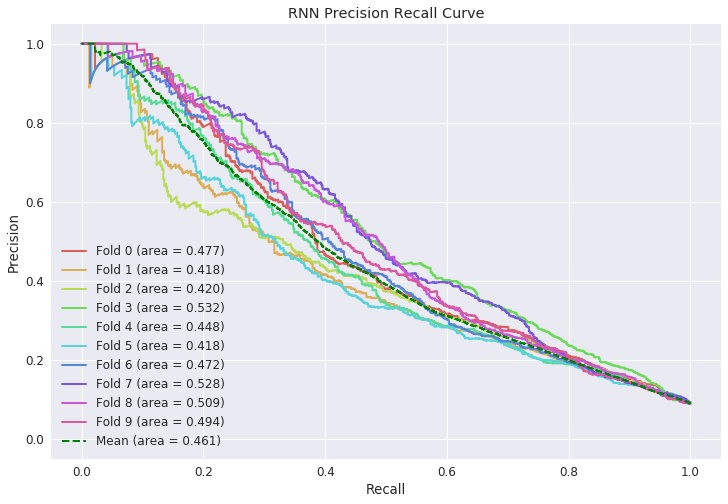

In [14]:
# pred_proba = cnn.predict([testX1,testX2]
y_real = []
y_proba = []

# colors = cycle(['cyan', 'crimson', 'seagreen', 'yellow', 'blue', 'darkorange', 'darkviolet', 'fuchsia',
#                'deepskyblue', 'lightcoral'])

sns.set(font_scale = 1.2)
colors = sns.hls_palette(10)
fig, ax = plt.subplots()
fig.set_size_inches(12.0, 8.0)

lw = 2
i = 0
precision_rnn = []
recall_rnn = []
threshold_rnn = []
f1_all = []
mcc_all = []
for i in range(10):
    testfile = "combined_Pseudouridine_test_%d.txt" % i
    test = read_composite_data(testfile)
    test_shuffled = test.sample(frac=1)
    seq_test,secstr_test,label_test = get_all_seq(test)
    testX,testY = onehotkey(seq_test,label_test)
    testY = np_utils.to_categorical(testY,2)
    testY = testY.reshape(-1,2)
    row1,col1 = testX[0].shape
    testX.shape = (testX.shape[0],row1,col1)
    cnn = models.load_model('%d-secstr_seq_denseconcat_100.h5' % i)
    color = colors[i]
    probas_ = cnn.predict(testX)
    pred_score = probas_[:,1]
    true_class = testY[:,1]
    precision, recall, thresholds = precision_recall_curve(true_class, pred_score)
    plt.plot(recall, precision, lw=lw, color=color,label='Fold %d (area = %0.3f)' % (i, auc(recall, precision)))
    y_real.append(true_class)
    y_proba.append(pred_score)
    precision_rnn.append(precision)
    recall_rnn.append(recall)
    threshold_rnn.append(thresholds)
    scores = np.where(pred_score > 0.5, 1, 0)
    precision_s = precision_score(true_class, scores)
    recall_s = recall_score(true_class, scores)
    f1_s = f1_score(true_class, scores)
    mcc = matthews_corrcoef(true_class,scores)
    f1_all.append(f1_s)
    mcc_all.append(mcc)
y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, thresholds = precision_recall_curve(y_real, y_proba)
precision_rnn.append(precision)
recall_rnn.append(recall)
threshold_rnn.append(thresholds)
plt.plot(recall, precision, lw=lw, color='g', linestyle='--',label='Mean (area = %0.3f)' % (auc(recall, precision)))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('RNN Precision Recall Curve')
plt.legend(loc="lower left")
plt.show()

In [35]:
np.mean(f1_all)

0.5196771094208175

In [36]:
np.mean(mcc_all)

0.54599025336203